<a href="https://colab.research.google.com/github/berk420/MetroPT-3_data_analyz/blob/main/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas_datareader as web
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,RepeatVector, TimeDistributed
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.stats as stats
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MetroPT3/MetroPT3(AirCompressor).csv')
csv_name='/content/drive/MyDrive/ColabNotebooks/MetroPT3/MetroPT3(AirCompressor).csv'
# airleak column adding
airleak_dates = [
    ('2020-04-18 00:00:00', '2020-04-18 23:59:00'),
    ('2020-05-29 23:30:00', '2020-05-30 06:00:00'),
    ('2020-06-05 10:00:00', '2020-06-07 14:30:00'),
    ('2020-07-15 14:30:00', '2020-07-15 19:00:00')
]

df['airleak'] = 0
for start_date, end_date in airleak_dates:
    df.loc[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date), 'airleak'] = 1

# airleakmaint column adding
airleakmaint_dates = [
    ('2020-04-30 12:00:00', '2020-04-30 12:01:00'),
    ('2020-06-08 16:00:00', '2020-06-08 16:01:00'),
    ('2020-07-16 00:00:00', '2020-07-16 00:01:00')
]

df['airleakmaint'] = 0
for start_date, end_date in airleakmaint_dates:
    df.loc[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date), 'airleakmaint'] = 1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-23-85c0259a8af0>:35: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MetroPT3/MetroPT3(AirCompressor).csv')


In [ ]:
df = df[['timestamp', 'DV_pressure','airleak']]
start_date = '2020-02-01 00:00:00'
end_date = '2020-09-01 03:59:50'
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)].copy()

Start date is:  2020-02-01 00:00:00
End date is:  2020-09-01 03:59:50


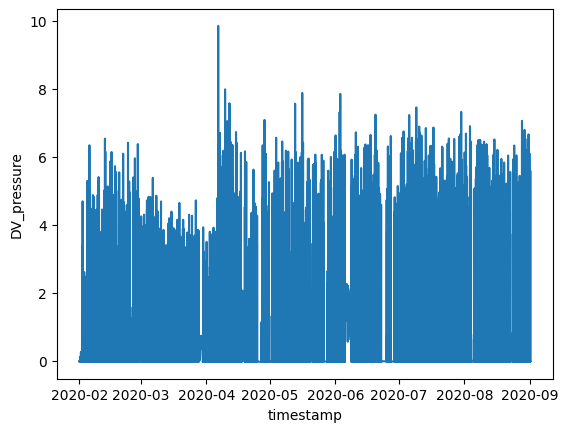

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

sns.lineplot(x=df['timestamp'], y=df['DV_pressure'])

print("Start date is: ", df['timestamp'].min())
print("End date is: ", df['timestamp'].max())

train, test = df.loc[df['timestamp'] <= '2020-06-25 10:00:00'], df.loc[df['timestamp'] > '2020-06-25 10:00:00']


In [ ]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer
scaler = StandardScaler()
scaler = scaler.fit(train[['DV_pressure']])

train['DV_pressure'] = scaler.transform(train[['DV_pressure']])
test['DV_pressure'] = scaler.transform(test[['DV_pressure']])


<ipython-input-26-f029be872488>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DV_pressure'] = scaler.transform(train[['DV_pressure']])
<ipython-input-26-f029be872488>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['DV_pressure'] = scaler.transform(test[['DV_pressure']])


In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 2. We will make timesteps = 3.
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 60  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['DV_pressure']], train['DV_pressure'], seq_size)
testX, testY = to_sequences(test[['DV_pressure']], test['DV_pressure'], seq_size)

In [ ]:
print(testX.shape)
print(testY.shape)
print(trainX.shape)
print(trainY.shape)

(478086, 60, 1)
(478086,)
(1038742, 60, 1)
(1038742,)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 60, 128)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 60, 128)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 60, 1)            129       
 tributed)                                            

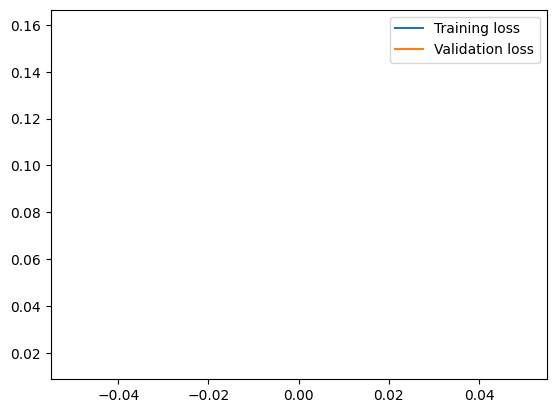

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))

# Define all loss functions
loss1 = tf.keras.losses.MeanSquaredError()
loss2 = tf.keras.losses.MeanAbsoluteError()
loss3 = tf.keras.losses.CategoricalCrossentropy()
loss4 = tf.keras.losses.BinaryCrossentropy()

# Compile the model with all loss functions
model.compile(optimizer='adam', loss=loss2)
model.summary()

history=model.fit(trainX, trainY, batch_size=64, epochs=1,validation_split=0.1,
                callbacks=callbacks, shuffle=False, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Add the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()




In [ ]:
fname = "weights/"+csv_name+'.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(fname, monitor="val_loss", mode="min",
save_best_only=True, verbose=0)
callbacks = [checkpoint]

Epoch 1/20
  701/10664 [>.............................] - ETA: 2:00:26 - loss: 0.0395

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(fname)


In [ ]:
x_train_pred = model.predict(x_train, verbose=0)
x_train_pred=np.reshape(x_train_pred,(x_train_pred.shape[0],x_train_pred.shape[1]))
# train_mae_loss = np.mean(np.abs(x_train_pred - x_train[:,0])/np.std(x_train_pred), axis=1)
train_mae_loss = (np.mean(np.abs(x_train_pred - x_train[:,0]), axis=1))

In [ ]:
threshold = 3*np.min(train_mae_loss)
x_test_pred = model.predict(x_test, verbose=0)
x_test_pred=np.reshape(x_test_pred,(x_test_pred.shape[0],x_test_pred.shape[1]))
test_mae_loss = np.mean(np.abs(x_test_pred-x_test[:,0]), axis=1)

In [ ]:
test_score_df = pd.DataFrame(df[training_data_len:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['thresholdmax'] = threshold+0.5
test_score_df['anomaly'] = ((test_score_df['loss'] <=threshold))

for i in test_score_df.index:
    if test_score_df['anomaly'][i]:
      test_score_df['anomaly'][i-Past] = True
      test_score_df['anomaly'][i] = False

anomalies = test_score_df.loc[(test_score_df['anomaly'] == True)]
anomalies.shape
ranomal=test_score_df.loc[(test_score_df['ranomaly'] == True)]
#precision=np.count(np.where(test_score_df['ranomaly'] and test_score_df['anomaly']))/(np.count(np.where(test_score_df['ranomaly'] and test_score_df['anomaly']))+np.count(np.where(not test_score_df['ranomaly'] and test_score_df['anomaly'])))
score = f1_score(test_score_df['ranomaly'], test_score_df['anomaly'], average="binary")
prec.append(score)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))
#fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['thresholdmax'], name='Threshold'))

fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
fig_an = go.Figure()
fig_an.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['value'], name='Value'))
fig_an.add_trace(go.Scatter(x=anomalies.index, y=anomalies['value'], mode='markers', name='Anomaly'))
#fig_an.add_trace(go.Scatter(x=ranomal.index, y=ranomal['value'], mode='markers', name='Real_Anomaly'))
fig_an.update_layout(showlegend=True, title='Detected anomalies-'+csv_name)
fig_an.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['value'], name='Value'))
fig.update_layout(showlegend=True, title='')
fig.show()